In [195]:
import math
import copy
import random
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

### Import file and compute distance matrix

In [196]:
city_points = np.loadtxt(open("hw2.csv", "rb"), delimiter=",")
dist_matrix = squareform(pdist(city_points, 'euclidean'))

### Helpers

In [197]:
# create a random solution
def random_tour(num_cities):
    numbers = list(range(1, num_cities))

    # Shuffling the list to get a random order
    random.shuffle(numbers)
    
    return numbers

def compute_tour_cost(cities):
    total_cost = 0
    for i in range(0, len(cities)-1):
        curr_cost = dist_matrix[cities[i]][cities[i+1]]
        total_cost += curr_cost
    total_cost += dist_matrix[cities[0]][cities[-1]]
    return total_cost

def exp_decay(time, init_temp=100, min_temp=0.001, exp_const=0.005):
    return max(init_temp * math.exp(-exp_const * time), min_temp)

def swap_cities(tour):
    tour_copy = copy.deepcopy(tour)
    rand_city_i1 = np.random.randint(0, len(tour))
    rand_city_i2 = np.random.randint(0, len(tour))
    
    while rand_city_i1 == rand_city_i2:
        rand_city_i2 = np.random.randint(0, len(tour))

    rand_city_1 = tour_copy[rand_city_i1]
    tour_copy[rand_city_i1] = tour_copy[rand_city_i2]
    tour_copy[rand_city_i2] = rand_city_1

    return tour_copy

## Simulated Annealing

In [198]:

def simulated_annealing(init_temp, max_iter=1000):
    curr_tour = random_tour(25)
    costs = np.zeros(max_iter)
    for i in range(0, max_iter):
        new_tour = swap_cities(curr_tour)

        old_cost = compute_tour_cost(curr_tour)
        new_cost = compute_tour_cost(new_tour)

        curr_temp = exp_decay(i, init_temp=init_temp)
        curr_cost = old_cost
        cost_diff = new_cost - old_cost


        if cost_diff < 0 or np.random.rand() < np.exp(-cost_diff / curr_temp):
            curr_tour = new_tour
            curr_cost = new_cost
        
        costs[i] = curr_cost
    return curr_tour, costs
    

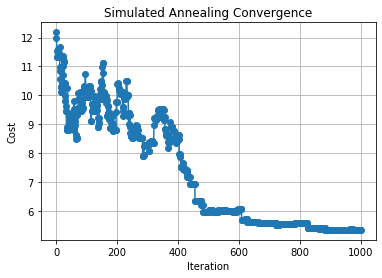

In [199]:
init_temp = 1
iterations = 1000
curr_tour, costs = simulated_annealing(init_temp, iterations)
plt.figure()
plt.plot(range(0, iterations), costs, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Simulated Annealing Convergence")
plt.grid(True)
plt.show()

## Evolutionary Algorithm

In [200]:
# mutation in this case is swapping two random cities in the tour
def evolutionary_algorithm(initial_tour_num, evolutions):
    costs = []
    # create k number of initial tours in the initial population
    population = []
    for _ in range(0,initial_tour_num):
        population.append(random_tour(25))

    for _ in range(0, evolutions):
        # generate k successor tours 
        successor_tours = []
        for tour in population:
            # mutation is to swap two tours
            successor_tours.append(swap_cities(tour))
        combined_populations = population + successor_tours
        # calculate the costs of all the tours
        all_costs = [compute_tour_cost(tour) for tour in combined_populations]
        # select the k best based on best = lowest cost
        combined_populations = list(zip(combined_populations, all_costs))
        sorted_populations = sorted(combined_populations, key = lambda x: x[1])
        # remove the k-worst
        new_population = [pair[0] for pair in sorted_populations[:(initial_tour_num)]]
        population = new_population
        costs.append(sorted_populations[0][1])

    return sorted_populations[0][0], costs



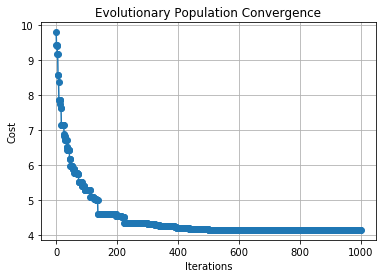

In [201]:
population_size = 20
iterations = 1000
curr_tour, costs = evolutionary_algorithm(population_size, iterations)
plt.figure()
plt.plot(range(0, iterations), costs, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Evolutionary Population Convergence")
plt.grid(True)
plt.show()

## Population-based Search

In [202]:
def population_based_search(beam_width, iterations):
    # start with k random tours
    tours = []
    for _ in range(0,beam_width):
        tours.append(random_tour(25))
    costs = []
    for _ in range (0, iterations):
        # generate successor tours
        successor_tours = []
        for tour in tours:
            # mutation is to swap two tours
            successor_tours.append(swap_cities(tour))
        combined_tours = tours + successor_tours
        # compute all the costs for the tours
        all_costs = [compute_tour_cost(tour) for tour in combined_tours]
        tours_with_costs = list(zip(combined_tours, all_costs))
        sorted_tours = sorted(tours_with_costs, key = lambda x: x[1])
        # select the top beam width tours
        new_set_tours = [pair[0] for pair in sorted_tours[:(beam_width)]]
        # save them for the next round
        tours = new_set_tours
        costs.append(sorted_tours[0][1])

    return sorted_tours[0][0], costs



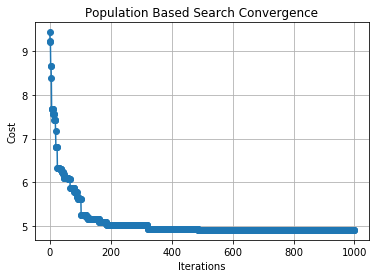

In [203]:
beam_width = 10
iterations = 1000
curr_tour, costs = population_based_search(beam_width, iterations)
plt.figure()
plt.plot(range(0, iterations), costs, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Population Based Search Convergence")
plt.grid(True)
plt.show()

## Experiments

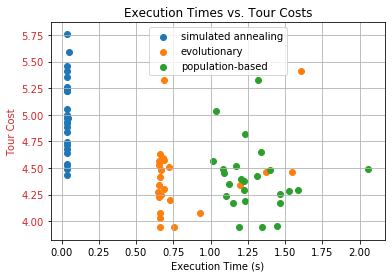

In [204]:
runs = 25
init_temp = 1
initial_num_tours = 20
beam_width = 20
iterations = 1000

sa_times = []
sa_cost = []
for _ in range(runs):
    start_time = time.time()  # Record the current time
    sa_tour, costs = simulated_annealing(init_temp, iterations)  # Call your function
    end_time = time.time()  # Record the time after the function completes
    execution_time = end_time - start_time
    sa_times.append(execution_time)
    sa_cost.append(costs[-1])

ea_times = []
ea_cost = []
for _ in range(runs):
    start_time = time.time()  # Record the current time
    ea_tour, costs = evolutionary_algorithm(initial_num_tours, iterations)  # Call your function
    end_time = time.time()  # Record the time after the function completes
    execution_time = end_time - start_time
    ea_times.append(execution_time)
    ea_cost.append(costs[-1])

ps_times = []
ps_cost = []
for _ in range(runs):
    start_time = time.time()  # Record the current time
    ps_tour, costs = population_based_search(beam_width, iterations)  # Call your function
    end_time = time.time()  # Record the time after the function completes
    execution_time = end_time - start_time
    ps_times.append(execution_time)
    ps_cost.append(costs[-1])

# Create a figure and axis
fig, ax = plt.subplots()

# Scatter plot for execution times
ax.set_xlabel('Execution Time (s)')
ax.set_ylabel('Tour Cost', color='tab:red')
ax.scatter(sa_times, sa_cost, label='simulated annealing', color='tab:blue')
ax.scatter(ea_times, ea_cost, label='evolutionary', color='tab:orange')
ax.scatter(ps_times, ps_cost, label='population-based', color='tab:green')
ax.tick_params(axis='y', labelcolor='tab:red')

# Add a legend
ax.legend()

# Set the axis labels
plt.xlabel('Execution Time (s)')
plt.title('Execution Times vs. Tour Costs')
plt.grid()

# Show the scatterplot
plt.show()

In [205]:
x_sa = [city_points[i][0] for i in sa_tour] 
y_sa = [city_points[i][1] for i in sa_tour] 
x_ea = [city_points[i][0] for i in ea_tour] 
y_ea = [city_points[i][1] for i in ea_tour] 
x_ps = [city_points[i][0] for i in ps_tour] 
y_ps = [city_points[i][1] for i in ps_tour] 

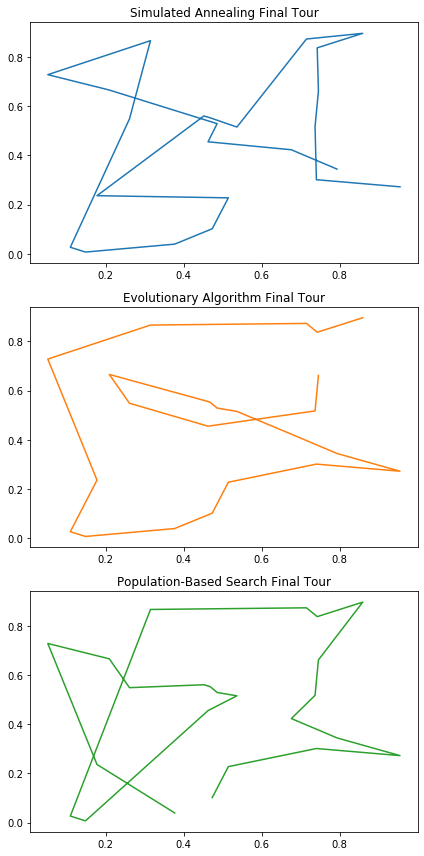

In [206]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

axs[0].plot(x_sa, y_sa, label='Simulated Annealing', color='tab:blue')
axs[1].plot(x_ea, y_ea, label='Evolutionary Algorithm', color='tab:orange')
axs[2].plot(x_ps, y_ps, label='Population-Based Search', color='tab:green')

# Set titles for  subplot
axs[0].set_title('Simulated Annealing Final Tour')
axs[1].set_title('Evolutionary Algorithm Final Tour')
axs[2].set_title('Population-Based Search Final Tour')

plt.tight_layout()

plt.show()
